## Anomalie

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [23]:
df= pd.read_csv("/customer_data.csv")
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


#### Przypadek jednowymiarowy
Na jednej ze zmiennych zidentyfikuj outliers wykorzystując:
1. metoda Tukeya - zmień z 1.5IQR na 2IQR (wyrysuj boxploty)
2. metoda Hamplela (MAD) (wyrysuj boxplot)
3. Z-score + zmodyfikowany

Tukey

Text(0, 0.5, 'Fresh')

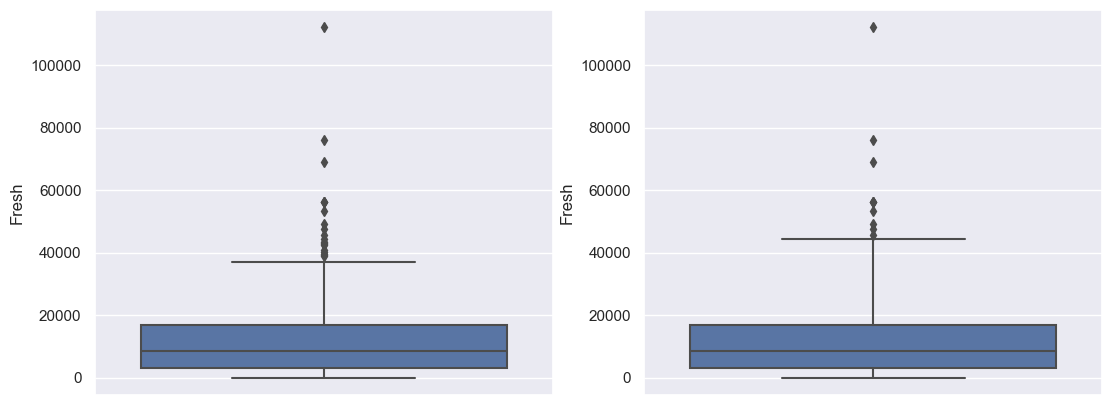

In [4]:
df=df[['Fresh']]

sns.set(rc={'figure.figsize':(13,5)})
fig, axs = plt.subplots(ncols=2)
sns.boxplot(y='Fresh', whis=1.5, data=df, ax=axs[0])
sns.boxplot(y='Fresh', whis=2, data=df, ax=axs[1])
plt.ylabel('Fresh')

In [4]:
#Tukey - ręcznie

In [6]:
def outlier_detection(column):
 sorted(column)
 Q1,Q3 = np.percentile(column , [25,75])
 IQR = Q3 - Q1
 lower_range = Q1 - (2 * IQR)
 upper_range = Q3 + (2* IQR)
 return lower_range,upper_range

lowerbound,upperbound = outlier_detection(df.Fresh)
len(df[(df.Fresh < lowerbound) | (df.Fresh > upperbound)])

10

Hampel

In [6]:
#pip install hampel
#from hampel import hampel
#import pandas as pd
#hampel(df, n=3)

In [8]:
def outlier_detection_Hampel(column):
 sorted(column)
 med=np.percentile(column , 50)
 List=abs(df-med)
 MAD=np.percentile(List, 50)*1.4826

 lower_range = med - (3 * MAD)
 upper_range = med + (3 * MAD)
 return lower_range,upper_range

lowerbound,upperbound = outlier_detection_Hampel(df.Fresh)
len(df[(df.Fresh < lowerbound) | (df.Fresh > upperbound)])
#df[(df.Fresh < lowerbound) | (df.Fresh > upperbound)]

25

Z-score + robust Z-score

In [8]:
m = np.mean(df.Fresh)
s = np.std(df.Fresh)
df['Z-score'] = (df.Fresh - m)/s
df_outlier = df[abs(df['Z-score']) >3]
len(df_outlier)

/var/folders/mj/086mzzjd2k78p0hhkqhhwzvr0000gn/T/ipykernel_10222/4182104706.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Z-score'] = (df.Fresh - m)/s


7

In [9]:
med = np.median(df.Fresh)
df['AD (Absolute Deviation)'] = abs(df.Fresh - med)
MAD = np.median(df['AD (Absolute Deviation)'])
df['Modified Z-score'] = (0.6745*df['AD (Absolute Deviation)'])/MAD
df_outlier = df[df['Modified Z-score'] >= 2.5]
len(df_outlier)

/var/folders/mj/086mzzjd2k78p0hhkqhhwzvr0000gn/T/ipykernel_10222/499528223.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AD (Absolute Deviation)'] = abs(df.Fresh - med)
/var/folders/mj/086mzzjd2k78p0hhkqhhwzvr0000gn/T/ipykernel_10222/499528223.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Modified Z-score'] = (0.6745*df['AD (Absolute Deviation)'])/MAD


33

#### Przypadek wielowymiarowy:
1. MCD Mahalanobis
2. DBSCAN
3. Isolation forest
4. LOF

In [27]:
df= pd.read_csv("/customer_data.csv")

Mahalanobis

In [28]:
# klasycznie
import scipy as sp
from scipy.stats import chi2

def mahalanobis(df):
    #M-Distance
    x_minus_mu = df - np.mean(df)
    cov = np.cov(df.values.T)                           
    inv_covmat = sp.linalg.inv(cov)                     #Inverse 
    left_term = np.dot(x_minus_mu, inv_covmat) 
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))    #chi2
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

In [29]:
outliers_mahal, md = mahalanobis(df.iloc[:,2:7])
len(outliers_mahal)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


16

In [30]:
#Robust Mahalonibis
from sklearn.covariance import MinCovDet

def robust_mahalanobis(df):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance 
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse 
    
    #Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1])) #chi2
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

In [31]:
robust_outliers_mahal, md = robust_mahalanobis(df.iloc[:,2:7])
len(outliers_mahal)

16

DBSCAN

In [24]:
# standaryzacja
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import RobustScaler - !
dataset = StandardScaler().fit_transform(df.iloc[:,2:7])

In [25]:
from sklearn.cluster import DBSCAN
# DBSCAN epsilon - promień sąsiedztwa, min_sample - min liczba obserwacji w promieniu
def delete_outliers_DBSCAN(df,eps,min_samples):
    outlier_detection = DBSCAN(eps = eps, min_samples = min_samples)
    clusters = outlier_detection.fit_predict(df.values.reshape(-1,1))
    data = pd.DataFrame()
    data['cluster'] = clusters
    return data['cluster']

In [37]:
clusters=delete_outliers_DBSCAN(df,0.1,12)
clusters.value_counts().sort_values(ascending=False)

-1    2631
 2     375
 1     325
 0     189
Name: cluster, dtype: int64

In [14]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
# https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(dataset)
neighbors_fit

NearestNeighbors(n_neighbors=20)

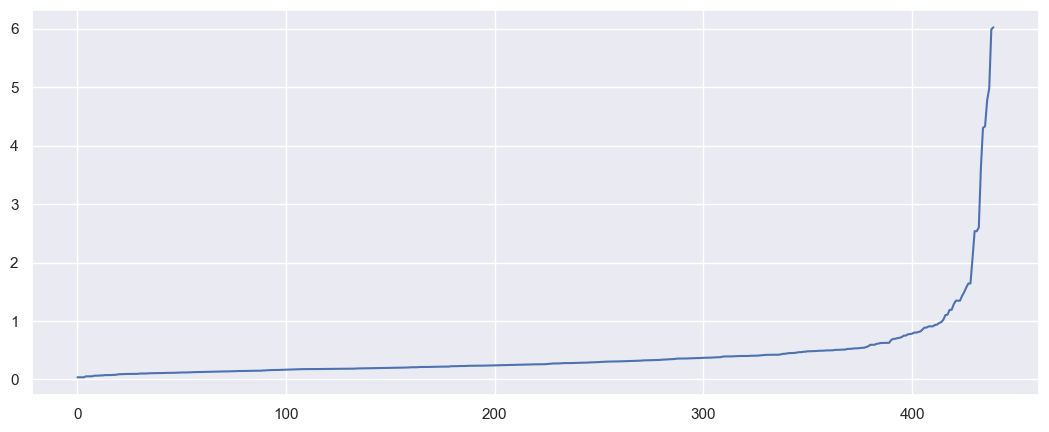

In [15]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
# https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(dataset)
distances, indices = neighbors_fit.kneighbors(dataset)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

0.6941079966012931


<Figure size 500x500 with 0 Axes>

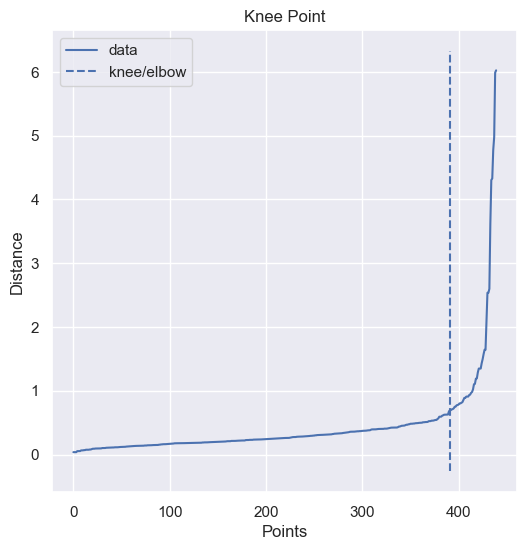

In [16]:
from kneed import KneeLocator #https://pypi.org/project/kneed/

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

#### Las izolacyjny 

In [38]:
df= pd.read_csv("/customer_data.csv")

In [42]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators = 100, random_state = 12, max_samples = 50, 
                      max_features = 5, contamination=0.1)
clf.fit(df.iloc[:,2:7])
anomalies = clf.predict(df.iloc[:,2:7])
anomalies

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1